# Production

In [ ]:
# model.predict(np.array([[[74.11]],[[75.1]],[[66]]])) #prod structure



1/1 [==============================] - 0s 68ms/step


array([[75.183136],
       [75.966934],
       [68.1463  ]], dtype=float32)

In [ ]:
# success configs:

# ticker = 'UNIP6.SA'
# start_date = '2024-01-08'
# end_date = '2024-11-29'
# window_size = 5

# ticker = 'KEPL3.SA'
# start_date = '2024-01-08'
# end_date = '2024-11-29'
# window_size = 5

# ticker = 'CSNA3.SA'
# start_date = '2024-01-08'
# end_date = '2024-11-29'
# window_size = 5

Epoch 1/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 3615.9905 - mean_absolute_error: 60.0896 - val_loss: 3740.4531 - val_mean_absolute_error: 61.1426
Epoch 2/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3527.7673 - mean_absolute_error: 59.3483 - val_loss: 3649.0728 - val_mean_absolute_error: 60.3907
Epoch 3/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3403.4141 - mean_absolute_error: 58.2960 - val_loss: 3534.1555 - val_mean_absolute_error: 59.4316
Epoch 4/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3327.9150 - mean_absolute_error: 57.6398 - val_loss: 3408.9304 - val_mean_absolute_error: 58.3686
Epoch 5/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3187.9106 - mean_absolute_error: 56.4144 - val_loss: 3252.6511 - val_mean_absolute_error: 57.0140
Epoch 6/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3052.7253 - mean_absolute_error: 55.1875 - val_loss: 3039.3169 - val_mean_absolute_error: 55.1112
Epoch 7/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2799.7080 - m

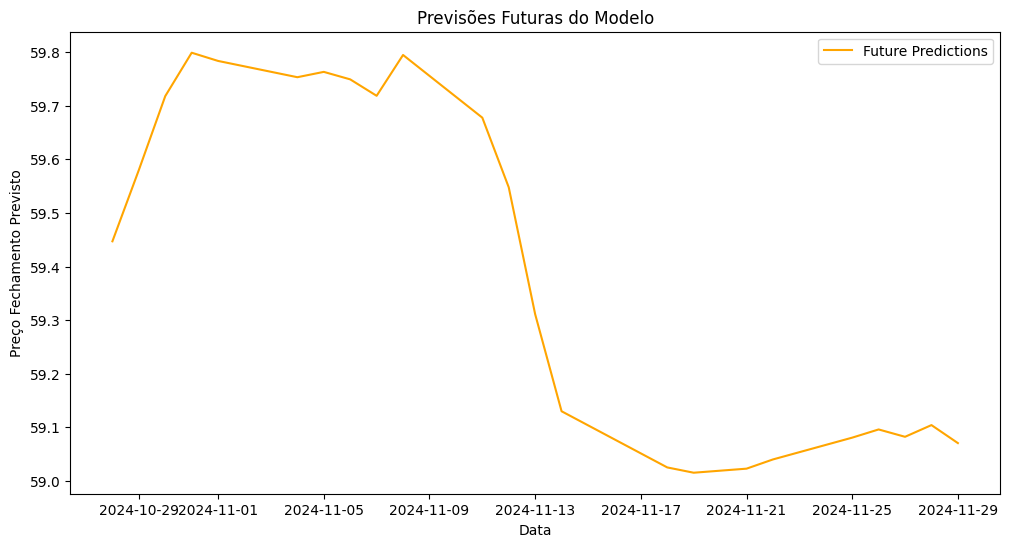

In [6]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
# Buscar preços reais
import plotly.graph_objects as go


# Função para converter string em datetime
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)


# Função para criar janelas de dados
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n):
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)

    target_date = first_date
    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n + 1)

        if len(df_subset) != n + 1:
            print(f'Erro: Janela de tamanho {n} é muito grande para a data {target_date}')
            return None

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date + datetime.timedelta(days=7)]
        if len(next_week) < 2:
            break

        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year, month, day = map(int, next_date_str.split('-'))
        next_date = datetime.datetime(year=year, month=month, day=day)

        if last_time:
            break

        target_date = next_date
        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(n):
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df

def adjust_dates_to_available(df, start_date, end_date):
    if start_date not in df.index:
        start_date = df.index[df.index.get_indexer([start_date], method='nearest')[0]]
        print(f'Data inicial ajustada para {start_date}')

    if end_date not in df.index:
        end_date = df.index[df.index.get_indexer([end_date], method='nearest')[0]]
        print(f'Data final ajustada para {end_date}')
    
    return start_date, end_date

# Função para converter janela para entrada do modelo
def windowed_df_to_date_X_y(windowed_dataframe):
    if windowed_dataframe is None or windowed_dataframe.empty:
        raise ValueError("O DataFrame de janela está vazio ou é None. Verifique as entradas.")

    df_as_np = windowed_dataframe.to_numpy()
    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)


# Treinamento do modelo
def train_model(ticker, start_date, end_date, window_size):
    df = yf.Ticker(ticker).history(period='max')
    df = df[['Close']]
    
    # Garantir que o índice seja datetime sem timezone e sem hora
    df.index = pd.to_datetime(df.index).tz_convert(None).normalize()

    # Garantir que start_date e end_date também estejam normalizadas
    start_date = pd.to_datetime(start_date).normalize()
    end_date = pd.to_datetime(end_date).normalize()

    start_date, end_date = adjust_dates_to_available(df, start_date, end_date)

    windowed_df = df_to_windowed_df(df, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'), n=window_size)

    if windowed_df is None or windowed_df.empty:
        raise ValueError("Erro: df_to_windowed_df retornou um DataFrame vazio ou None.")

    dates, X, y = windowed_df_to_date_X_y(windowed_df)

    q_80 = int(len(dates) * .8)
    q_90 = int(len(dates) * .9)

    dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
    dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
    dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

    model = Sequential([
        layers.Input((window_size, 1)),
        layers.LSTM(70),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mse',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=65)

    return model, dates_test, X_test


# Parâmetros do modelo
ticker = 'VALE3.SA'
start_date = '2024-01-08'
end_date = '2024-11-29'
window_size = 5

# Treinamento do modelo
model, dates_test, X_test = train_model(ticker, start_date, end_date, window_size)

# Predições para datas futuras
future_predictions = model.predict(X_test).flatten()

# Plot das previsões futuras
plt.figure(figsize=(12, 6))
plt.plot(dates_test, future_predictions, label='Future Predictions', color='orange')
plt.title('Previsões Futuras do Modelo')
plt.xlabel('Data')
plt.ylabel('Preço Fechamento Previsto')
plt.legend()
plt.show()
#=============== in case you have the data
def get_actual_prices(ticker, start_date, end_date):
    df = yf.Ticker(ticker).history(start=start_date, end=end_date)
    df = df[['Close']]
    df.index = pd.to_datetime(df.index).normalize()
    return df


# Buscar preços reais
actual_prices_df = get_actual_prices(ticker, start_date, end_date)
actual_dates = actual_prices_df.index
actual_prices = actual_prices_df['Close'].to_numpy()

# Plot com Plotly
fig = go.Figure()

# Adicionar previsões futuras
fig.add_trace(go.Scatter(
    x=dates_test,
    y=future_predictions,
    mode='lines',
    name='Future Predictions',
    line=dict(color='orange')
))

# Adicionar preços reais
fig.add_trace(go.Scatter(
    x=actual_dates,
    y=actual_prices,
    mode='lines',
    name='Actual Prices',
    line=dict(color='blue')
))

# Layout do gráfico
fig.update_layout(
    title='Comparação entre Previsões e Preços Reais',
    xaxis_title='Data',
    yaxis_title='Preço Fechamento',
    legend=dict(x=0, y=1),
    template='plotly_dark',
    hovermode='x unified',
    width=1000,
    height=600
)

# Mostrar gráfico
fig.show()


In [ ]:
# import pandas as pd
# import numpy as np
# import datetime
# import yfinance as yf
# import matplotlib.pyplot as plt
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import layers
# from tensorflow.keras.callbacks import EarlyStopping
# import plotly.graph_objects as go

# # Função para calcular indicadores técnicos
# def add_technical_indicators(df):
#     df['SMA_10'] = df['Close'].rolling(window=10).mean()
#     df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
#     df['RSI'] = compute_rsi(df['Close'])
#     df.fillna(method='bfill', inplace=True)
#     return df

# # Função para calcular RSI
# def compute_rsi(series, period=14):
#     delta = series.diff()
#     gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
#     loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
#     rs = gain / loss
#     return 100 - (100 / (1 + rs))

# # Função para criar janelas de dados
# def df_to_windowed_df(dataframe, first_date_str, last_date_str, n):
#     first_date = str_to_datetime(first_date_str)
#     last_date = str_to_datetime(last_date_str)

#     target_date = first_date
#     dates = []
#     X, Y = [], []

#     while True:
#         df_subset = dataframe.loc[:target_date].tail(n + 1)

#         if len(df_subset) != n + 1:
#             print(f'Erro: Janela de tamanho {n} é muito grande para a data {target_date}')
#             return None

#         x_features = df_subset.drop(columns=['Close']).to_numpy()
#         y = df_subset['Close'].iloc[-1]

#         dates.append(target_date)
#         X.append(x_features[:-1])
#         Y.append(y)

#         next_week = dataframe.loc[target_date:target_date + datetime.timedelta(days=7)]
#         if len(next_week) < 2:
#             break

#         next_date_str = next_week.head(2).index[-1].strftime('%Y-%m-%d')
#         target_date = str_to_datetime(next_date_str)
#         if target_date >= last_date:
#             break

#     return pd.DataFrame({'Target Date': dates, 'X': X, 'Y': Y})

# # Treinamento do modelo
# def train_model(ticker, start_date, end_date, window_size):
#     df = yf.Ticker(ticker).history(period='max')
#     df = df[['Close']]
    
#     # Garantir que o índice seja datetime sem timezone e sem hora
#     df.index = pd.to_datetime(df.index).tz_convert(None).normalize()

#     # Garantir que start_date e end_date também estejam normalizadas
#     start_date = pd.to_datetime(start_date).normalize()
#     end_date = pd.to_datetime(end_date).normalize()

#     start_date, end_date = adjust_dates_to_available(df, start_date, end_date)

#     windowed_df = df_to_windowed_df(df, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'), n=window_size)
    
#     dates, X, y = windowed_df['Target Date'], np.array(windowed_df['X'].tolist()), np.array(windowed_df['Y'].tolist())

#     q_80, q_90 = int(len(dates) * .8), int(len(dates) * .9)
#     X_train, y_train = X[:q_80], y[:q_80]
#     X_val, y_val = X[q_80:q_90], y[q_80:q_90]
#     X_test, y_test = X[q_90:], y[q_90:]

#     model = Sequential([
#         layers.Input(shape=(window_size, X.shape[2])),
#         layers.Bidirectional(layers.LSTM(70, return_sequences=True)),
#         layers.Dropout(0.2),
#         layers.Bidirectional(layers.LSTM(50)),
#         layers.Dense(32, activation='relu'),
#         layers.Dense(1)
#     ])

#     model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
#     early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
#     model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[early_stop])
#     return model, dates[q_90:], X_test

# # Configuração
# ticker = 'UNIP6.SA'
# start_date = '2024-01-08'
# end_date = '2024-11-29'
# window_size = 10

# model, dates_test, X_test = train_model(ticker, start_date, end_date, window_size)

# # Predições
# future_predictions = model.predict(X_test).flatten()

# # Comparação com preços reais
# actual_prices_df = get_actual_prices(ticker, start_date, end_date)
# actual_dates = actual_prices_df.index
# actual_prices = actual_prices_df['Close'].to_numpy()

# # Gráficos
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=dates_test, y=future_predictions, mode='lines', name='Future Predictions', line=dict(color='orange')))
# fig.add_trace(go.Scatter(x=actual_dates, y=actual_prices, mode='lines', name='Actual Prices', line=dict(color='blue')))
# fig.update_layout(title='Comparação entre Previsões e Preços Reais', xaxis_title='Data', yaxis_title='Preço Fechamento', template='plotly_dark')
# fig.show()


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 2936.8250 - val_loss: 2104.8176
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2982.1831 - val_loss: 2104.2671
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2981.3203 - val_loss: 2103.7170
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3000.6926 - val_loss: 2103.1670
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2993.7407 - val_loss: 2102.6172
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2968.9639 - val_loss: 2102.0679
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2950.6240 - val_loss: 2101.5181
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2985.0547 - val_loss: 2100.9685
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2970.3113 - val_loss: 2100.4185
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2927.9507 - val_loss: 2099.8689
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2942.5930 - val_loss: 2099.3188
Epoch 1